### ResNet50

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input

# 랜덤 시드 설정 (항상 동일한 변형이 적용되도록)
np.random.seed(12345)
tf.random.set_seed(12345)

In [17]:
# 사용자 정의 증강 함수 (이미지 5가지 중 하나를 선택하여 적용)
def custom_augmentation(image):
    augmentation_type = np.random.choice(
        ["rotation", "zoom", "shear", "crop", "horizontal_flip"]
    )

    if augmentation_type == "rotation":
        # 회전 각도를 무작위로 선택 (45, 90, 135, ..., 315)
        angles = [45, 90, 135, 180, 225, 270, 315]
        angle = np.random.choice(angles)
        image = tf.keras.preprocessing.image.random_rotation(image, angle)

    elif augmentation_type == "zoom":
        # 크기 확대/축소
        image = tf.keras.preprocessing.image.random_zoom(
            image, (0.8, 1.2), fill_mode="nearest"
        )

    elif augmentation_type == "shear":
        # 찌그러뜨리기
        image = tf.keras.preprocessing.image.random_shear(
            image, 0.2, fill_mode="nearest"
        )

    elif augmentation_type == "crop":
        # 이미지 크롭
        image = tf.keras.preprocessing.image.random_shift(
            image, 0.2, 0.2, fill_mode="nearest"
        )

    elif augmentation_type == "horizontal_flip":
        # 좌우 반전
        image = tf.image.flip_left_right(image)

    return image

In [18]:
# 원본 데이터를 사용한 ImageDataGenerator
original_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet50에 맞춘 전처리 적용
)

# 변형된 이미지를 추가하기 위한 ImageDataGenerator
augmented_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=custom_augmentation,  # 사용자 정의 증강 함수 적용
)

# 검증 데이터는 따로 경로에서 불러오되, 배치 단위로 불러오고 정규화하기 위해 생성기 사용
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet50에 맞춘 전처리 적용
)

In [19]:
# 데이터 경로 설정
train_data_dir = "horse-or-human/"
validation_data_dir = "validation-horse-or-human/"
img_size = (224, 224)

In [29]:
# 배치 크기를 32로 설정
batch_size = 32

# 원본 이미지 생성기
original_generator = original_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 원본 데이터 배치 크기 설정
    class_mode="binary",
)

# 변형된 이미지 생성기
augmented_generator = augmented_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 변형된 데이터 배치 크기 설정
    class_mode="binary",
)

# 검증 데이터 생성기 (경로에서 불러오면서 정규화 및 배치 처리)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
)

Found 1027 images belonging to 2 classes.
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [30]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [31]:
# Fine-tuning: 하위 150개 레이어를 고정하고 상위 레이어를 학습 가능하게 설정
for layer in base_model.layers[:150]:
    layer.trainable = False
for layer in base_model.layers[150:]:
    layer.trainable = True

In [32]:
# 모델 구성
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [33]:
# EarlyStopping과 Learning Rate Scheduler 설정
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5
)

In [34]:
# 두 개의 데이터 제너레이터를 합치는 함수 (원본 1027개 + 변형된 1027개)
def combined_generator(original_gen, augmented_gen):
    while True:
        original_data = next(original_gen)
        augmented_data = next(augmented_gen)
        combined_data = np.concatenate([original_data[0], augmented_data[0]], axis=0)
        combined_labels = np.concatenate([original_data[1], augmented_data[1]], axis=0)
        yield combined_data, combined_labels


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,727,105 (90.51 MB)

 Trainable params: 10,125,441 (38.63 MB)

 Non-trainable params: 13,601,664 (51.89 MB)

In [35]:
# 모델 학습 (에포크당 1027개 원본 + 1027개 변형된 데이터로 총 2054개 학습)
# 총 에포크 10개, 배치사이즈 32개
history = model.fit(
    combined_generator(original_generator, augmented_generator),
    steps_per_epoch=len(original_generator),  # 배치 크기에 맞춘 steps_per_epoch
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10,
    callbacks=[lr_scheduler],
    verbose=1,
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6448 - loss: 0.5916 - val_accuracy: 0.7891 - val_loss: 0.4299 - learning_rate: 1.0000e-05
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8019 - loss: 0.3663 - learning_rate: 1.0000e-05
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8276 - loss: 0.3330 - val_accuracy: 0.9453 - val_loss: 0.2163 - learning_rate: 1.0000e-05
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8669 - loss: 0.3057 - learning_rate: 1.0000e-05
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8879 - loss: 0.2572 - val_accuracy: 0.9844 - val_loss: 0.1353 - learning_rate: 1.0000e-05
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9029 - loss: 0.2166 - learning_rate: 1.0000e-05
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9242 - loss: 0.1868 - val_accuracy: 1.0000 - val_loss: 0.0834 - learning_rate: 1.0000e-05
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/ste

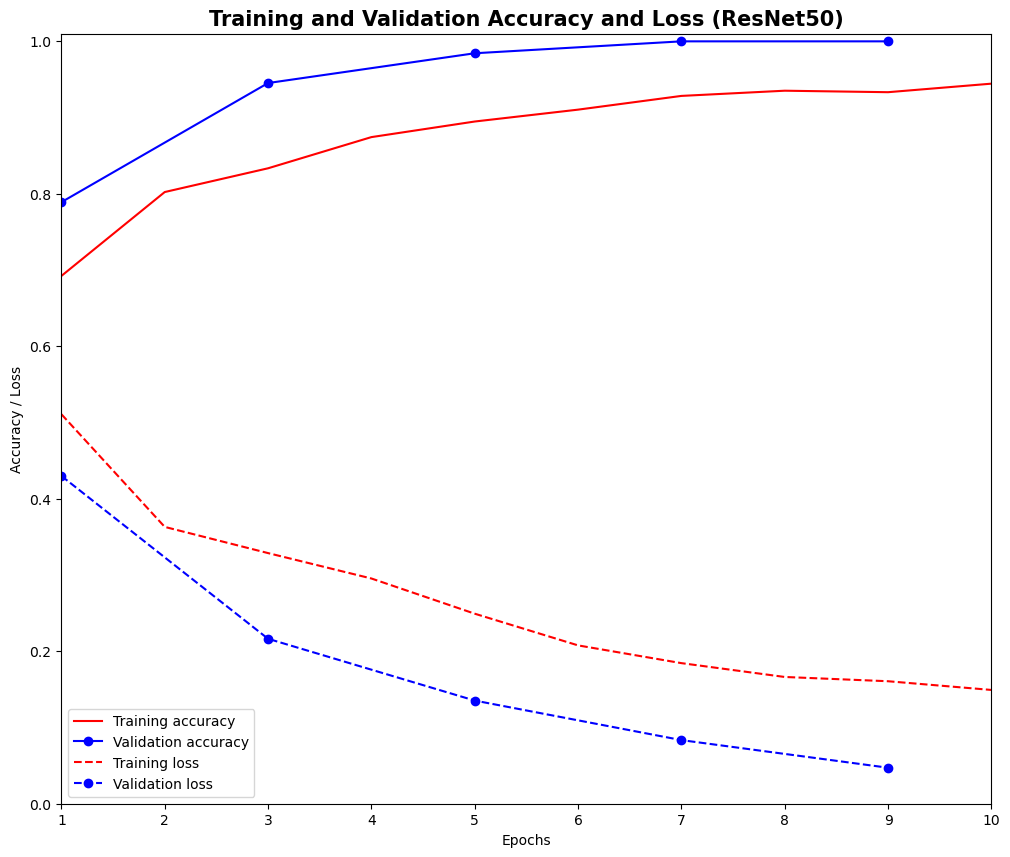

In [44]:
# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
num_epochs = 10
# 에포크 범위 설정
plt.figure(figsize=(12, 10))
epochs = range(1, num_epochs + 1)  # x축을 1부터 num_epochs까지 설정
# 정확도 시각화
plt.plot(epochs, acc[:num_epochs], "r", label="Training accuracy")
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_acc,  # y축: 검증 정확도
    "b",
    label="Validation accuracy",
    marker="o",
)
# 손실 시각화
plt.plot(epochs, loss[:num_epochs], "r--", label="Training loss")
# Validation loss: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_loss,  # y축: 검증 손실
    "b--",
    label="Validation loss",
    marker="o",
)
# 그래프 제목 및 레이블 설정
plt.title(
    "Training and Validation Accuracy and Loss (ResNet50)",
    fontsize="15",
    fontweight="bold",
)
plt.xlabel("Epochs", fontsize="10")
plt.ylabel("Accuracy / Loss", fontsize="10")
plt.legend()
# x축 범위 설정
plt.xlim(1, num_epochs)  # x축 범위를 1에서 num_epochs까지 설정
plt.ylim(0, 1.01)
# 그래프 표시
plt.show()

In [52]:
print(epochs)
print(val_acc)

range(1, 11)
[0.7890625, 0.9453125, 0.984375, 1.0, 1.0]


In [48]:
# 모델 저장
model.save("ResNet50.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step


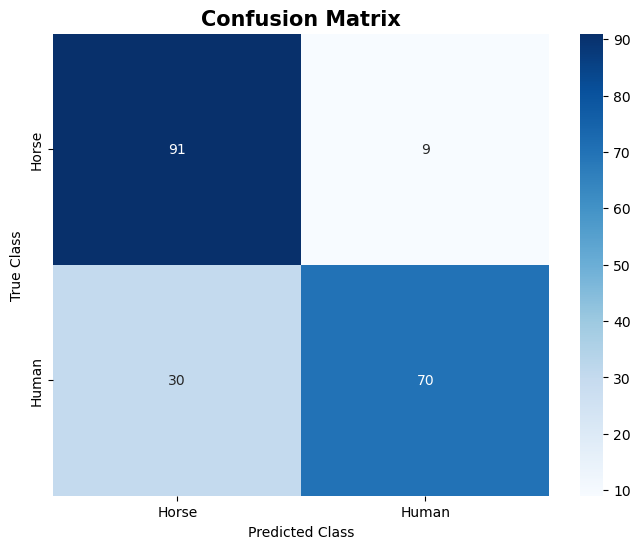

              precision    recall  f1-score   support

       Horse       0.75      0.91      0.82       100
       Human       0.89      0.70      0.78       100

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.82      0.81      0.80       200



In [60]:
import os
import numpy as np
import cv2  # OpenCV를 사용하여 이미지 로드
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 테스트 이미지 경로 설정
test_dir = "test1/"  # test1 폴더 경로

# 이미지 크기 설정 (ResNet50 모델에 맞게 224x224)
img_size = (224, 224)


# 이미지 파일을 불러오는 함수
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)  # 이미지 크기를 224x224로 조정
            img = preprocess_input(img)  # ResNet50에 맞춘 전처리 적용
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames


# 말과 사람의 이미지 불러오기
test_images, filenames = load_images_from_folder(test_dir)

# 예측 수행
predictions = model.predict(test_images)

# 예측값을 이진화 (0.5 이상이면 Human, 아니면 Horse)
predicted_classes = (predictions > 0.5).astype(int)

# 파일 이름에서 실제 클래스 추출 (여기서는 'human'과 'horse'가 파일명에 포함된다고 가정)
true_classes = [1 if "human" in filename.lower() else 0 for filename in filenames]

# 혼동행렬 생성
cm = confusion_matrix(true_classes, predicted_classes)

# 혼동행렬 시각화 (히트맵)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Horse", "Human"],
    yticklabels=["Horse", "Human"],
)
plt.title("Confusion Matrix", fontsize='15', fontweight='bold')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# 분류 보고서 출력
report = classification_report(
    true_classes, predicted_classes, target_names=["Horse", "Human"]
)
print(report)